In [1]:
import numpy as np
import tensorflow as tf
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array

# Dataset path
data_path = "/kaggle/input/signlang"

# Load and preprocess the dataset
def load_data(data_path, img_size=(64, 64), sequence_length=5):
    X, y = [], []
    labels = sorted(os.listdir(os.path.join(data_path, "Train")))
    label_dict = {label: idx for idx, label in enumerate(labels)}
    
    for label in labels:
        label_path = os.path.join(data_path, "Train", label)
        images = sorted(os.listdir(label_path))
        
        # Group images into sequences
        for i in range(0, len(images) - sequence_length + 1, sequence_length):
            frames = []
            for j in range(sequence_length):
                img_path = os.path.join(label_path, images[i + j])
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = img_to_array(img) / 255.0  # Normalize
                frames.append(img)
            X.append(frames)
            y.append(label_dict[label])
    
    X = np.array(X)
    y = to_categorical(y, num_classes=len(labels))
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_data(data_path)

# Build the CNN-LSTM model
def build_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        Dropout(0.2),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        Dropout(0.2),
        TimeDistributed(Flatten()),
        
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model((5, 64, 64, 3), len(os.listdir(os.path.join(data_path, "Train"))))

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {acc:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.0655 - loss: 3.1644 - val_accuracy: 0.3510 - val_loss: 2.0507
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5803 - loss: 1.4311 - val_accuracy: 0.9152 - val_loss: 0.2782
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9588 - loss: 0.1996 - val_accuracy: 0.9927 - val_loss: 0.0477
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9972 - loss: 0.0434 - val_accuracy: 0.9973 - val_loss: 0.0150
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9994 - loss: 0.0160 - val_accuracy: 0.9927 - val_loss: 0.0276
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9989 - loss: 0.0131 - val_accuracy: 0.9982 - val_loss: 0.0080
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9993 - loss: 0.0064 - val_accuracy: 0.9982 - val_loss: 0.0056
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9999 - loss: 0.0060 - val_accu

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step


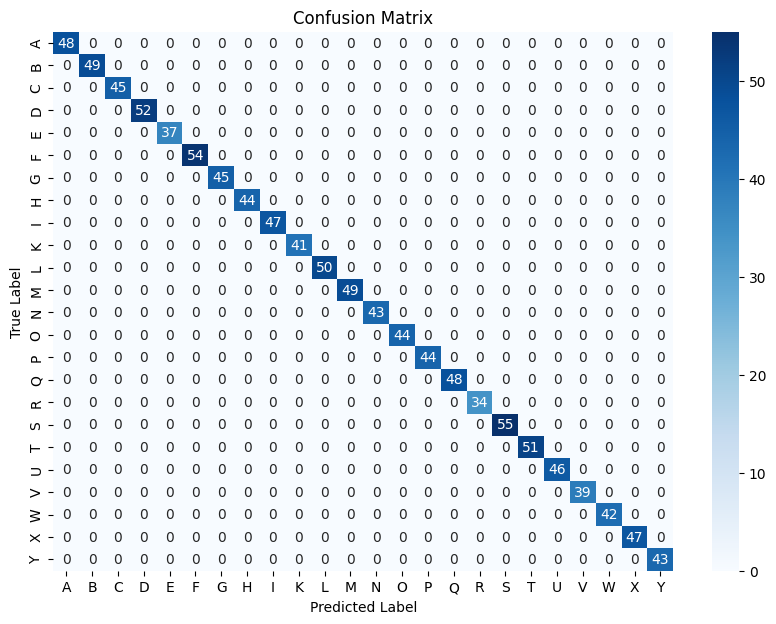

In [4]:
# Define class labels from dataset
labels = sorted(os.listdir(os.path.join(data_path, "Train")))

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [5]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=labels))


Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        48
           B       1.00      1.00      1.00        49
           C       1.00      1.00      1.00        45
           D       1.00      1.00      1.00        52
           E       1.00      1.00      1.00        37
           F       1.00      1.00      1.00        54
           G       1.00      1.00      1.00        45
           H       1.00      1.00      1.00        44
           I       1.00      1.00      1.00        47
           K       1.00      1.00      1.00        41
           L       1.00      1.00      1.00        50
           M       1.00      1.00      1.00        49
           N       1.00      1.00      1.00        43
           O       1.00      1.00      1.00        44
           P       1.00      1.00      1.00        44
           Q       1.00      1.00      1.00        48
           R       1.00      1.00      1.00        34
   